In [345]:
import os
import numpy as np
import eilib as eil
import stimlib as st
from scipy.io import loadmat
from scipy.optimize import minimize, differential_evolution, dual_annealing
import matplotlib.pyplot as plt
import importlib as il
import datetime
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
import pandas as pd
from tabulate import tabulate
il.reload(eil)

<module 'eilib' from '/Users/qwertyunicorn/Downloads/eilib.py'>

In [346]:
## Load in electrode array map 
adj_mat = loadmat('/Users/qwertyunicorn/Downloads/real_data/elec_files/adj_mat_512.mat')
elec_coords = loadmat('/Users/qwertyunicorn/Downloads/real_data/elec_files/512Coords.mat')['coords']

In [347]:
print(adj_mat['adj_mat_512'][427][0][0])

[419 420 427 429 435 436]


In [348]:
## Load in electrical image data
eipath = '/Users/qwertyunicorn/Downloads/real_data/2015-04-14-0/data000/data000_forpy.mat'
eis = st.loadEis(eipath)
ei_cell_ids = st.loadEiCellIds(eipath)

In [349]:
print(ei_cell_ids)

[1, 2, 16, 31, 34, 46, 76, 91, 106, 107, 108, 113, 121, 151, 158, 182, 198, 212, 215, 227, 230, 256, 257, 271, 286, 305, 332, 333, 336, 361, 362, 365, 376, 377, 391, 392, 406, 410, 425, 436, 481, 496, 498, 499, 512, 526, 543, 556, 572, 586, 587, 588, 589, 602, 604, 616, 617, 631, 632, 633, 634, 647, 661, 681, 692, 694, 707, 721, 736, 738, 781, 796, 811, 826, 827, 841, 871, 877, 887, 901, 917, 931, 933, 947, 961, 962, 978, 991, 1023, 1038, 1040, 1054, 1067, 1070, 1071, 1072, 1082, 1096, 1097, 1099, 1112, 1113, 1141, 1159, 1171, 1174, 1216, 1217, 1233, 1234, 1248, 1261, 1263, 1276, 1291, 1292, 1293, 1308, 1309, 1321, 1322, 1323, 1336, 1353, 1366, 1367, 1373, 1382, 1383, 1396, 1445, 1446, 1448, 1460, 1472, 1504, 1508, 1516, 1531, 1538, 1549, 1562, 1591, 1607, 1608, 1609, 1621, 1622, 1637, 1639, 1651, 1652, 1681, 1699, 1711, 1727, 1728, 1729, 1742, 1771, 1772, 1773, 1786, 1787, 1801, 1803, 1818, 1819, 1831, 1862, 1876, 1883, 1891, 1892, 1895, 1906, 1922, 1936, 1951, 1953, 1958, 1971, 1982,

In [350]:
testElecs = {2416 : [298, 337, 345, 373, 279], 1171 : [40, 378, 375, 418, 355], 2612 : [311, 291, 330, 350, 369, 400], 1891 : [68, 56, 347, 359, 370, 382, 409], 512: [440, 433, 427, 413], 5326: [425, 418, 412]}
testNeighbors = {2416 : [2612], 1171 : [1891, 512], 512 : [1099], 5326 : [512]}

In [351]:
## Pick out a neuron and plot it
nid = [5326, 512]
nidx = [ei_cell_ids.index(n) for n in nid]
ei = [np.min(eis[nx,0], axis=1) for nx in nidx]
neuronData = {'nid': nid, 'nidx': nidx, 'ei': ei, 'soma_pos':[], 'x': [], 'p':[], 'soma_elecs': [] , 'axon_elecs': [], 'mixed_elecs': [], 'dend_elecs': []}
#nid = 1159
#nidx = ei_cell_ids.index(nid)
#ei = np.min(eis[nidx,0], axis=1)

In [352]:
## Get cell compartments by looking at signal
for index in range(len(nidx)):
    soma_elecs = []
    axon_elecs = []
    mixed_elecs = []
    dend_elecs = []

    eiThr = -2
    mysf = -5
    mixedDiff = 0.1
    goodInds = np.nonzero(ei[index]<eiThr)[0]
    for goodInd in goodInds:
        wave = eis[nidx[index],0][goodInd,:].flatten()
        try: 
            if eil.axonorsoma(wave, mixed_diff_perc = mixedDiff) in ['soma']:
                soma_elecs.append(goodInd)
            elif eil.axonorsoma(wave, mixed_diff_perc = mixedDiff) in ['axon']:
                axon_elecs.append(goodInd)
            elif eil.axonorsoma(wave, mixed_diff_perc = mixedDiff) in ['mixed']:
                mixed_elecs.append(goodInd)
            elif eil.axonorsoma(wave, mixed_diff_perc = mixedDiff) in ['dendrite']:
                dend_elecs.append(goodInd)
            else:
                soma_elecs.append(goodInd)
        except IndexError:
            continue

    ## Calculate soma position
    weightlist = np.array(soma_elecs)/sum(soma_elecs)
    # Get cell coordinates
    soma_elec_coords_x = [elec_coords[j,0] for j in soma_elecs]
    soma_elec_coords_y = [elec_coords[j,1] for j in soma_elecs]
    # Compute average position
    xcoord = np.dot(soma_elec_coords_x, weightlist)
    ycoord = np.dot(soma_elec_coords_y, weightlist)
    soma_pos = [xcoord,ycoord]
    
    ## Get axon fit
    (p, pder, dirflg, fitx) = eil.getAxonFitNew(eis[nidx[index],0], soma_pos, elec_coords, adj_mat, thr = -2, pdeg = 2)
    numpts = 200
    x = np.linspace(np.min(fitx),np.max(fitx),numpts)

    #save all lists/variables created and later used
    neuronData['soma_pos'].append(soma_pos)
    neuronData['soma_elecs'].append(soma_elecs)
    neuronData['axon_elecs'].append(axon_elecs)
    neuronData['mixed_elecs'].append(mixed_elecs)
    neuronData['dend_elecs'].append(dend_elecs)
    neuronData['x'].append(x)
    neuronData['p'].append(p)

In [353]:
neuronData = pd.DataFrame(neuronData)

Neuron:  5326
Neuron:  512


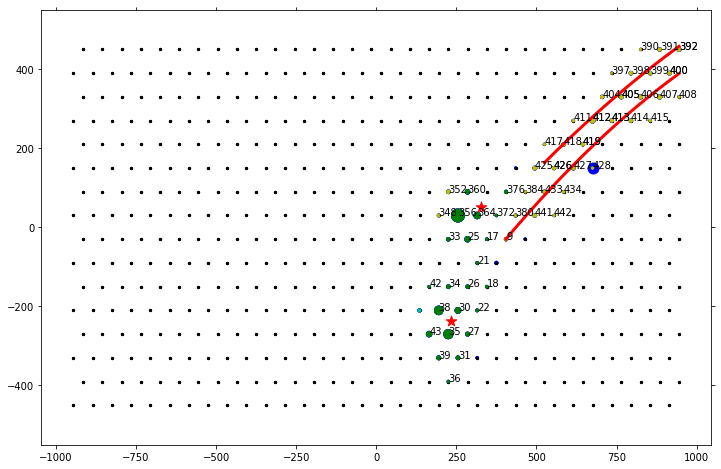

In [363]:
## Plot
#plt.close('all')
fig,ax = plt.subplots(1,1, figsize=(12,8))
for i, row in neuronData.iterrows():
    print('Neuron: ', row['nid'])
    eil.plotEiMarked(row['ei'], row['axon_elecs'], ax, elec_coords, size_fac=mysf,mymarkedfc='y',myalpha=1,mymarkedalpha=1,noArray=True,thr=-2)
    eil.plotEiMarked(row['ei'], row['soma_elecs'], ax, elec_coords, size_fac=mysf,mymarkedfc='g',myalpha=1,mymarkedalpha=1,noArray=True,thr=-2)
    eil.plotEiMarked(row['ei'], row['dend_elecs'], ax, elec_coords, size_fac=mysf,mymarkedfc='c',myalpha=1,mymarkedalpha=1,noArray=True,thr=-2)
    ax.scatter(row['soma_pos'][0],row['soma_pos'][1],marker='*',color='r',s=120,zorder=3)
    ax.plot(row['x'], row['p'](row['x']),lw=3,color='r')
    ## Add labels for the stimulating electrodes and EI electrodes.
    xcoords = elec_coords[:,0]
    ycoords = elec_coords[:,1]
    for e in row['soma_elecs']:
        ax.annotate((e+1),(xcoords[e],ycoords[e]),size=10)
    for e in row['axon_elecs']:
        ax.annotate((e+1),(xcoords[e],ycoords7[e]),size=10)
    eil.plotArrayOnly(ax, elec_coords, size=5, myalpha=1, myfc='k', myec='k')
ax.scatter(elec_coords[427][0], elec_coords[42][1], marker='o',color='b', s =120)    
plt.show()

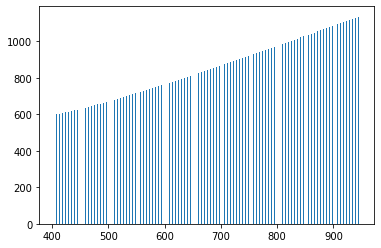

In [365]:
distances = []
for x in neuronData['x'][1]:
    distances.append((np.sqrt((elec_coords[298][0]-x)**2 + (elec_coords[298][1]-neuronData['p'][0](x))**2), x))
height, length = zip(*distances)
plt.bar(length, height)
plt.show()

In [366]:
#calculating the activation function of a axon due to an electrode
def actFun(p_e, i, step, ex, ey, x_all, y, p):
  all_r = [] #store the distances
  graph = [] #store actfunc values
  for index in range(len(x_all)):
    x = x_all[index]
    axon = np.array([x * (10**(-4)),y[index] * (10**(-4))]) #convert points from microns to cm
    elec = np.array([ex * (10**(-4)), ey * (10**(-4))])
    r = np.sqrt((axon[0]-elec[0])**2 + (axon[1]-elec[1])**2)
    all_r.append((r,x))
    r_2d = elec-axon 
    dV_dr = p_e * i * -1/(4 * np.pi * r)
    dl = np.array([x + step, p(x + step)]) - np.array([x - step, p(x - step)])
    dl = dl/np.linalg.norm(dl)
    dV_dr_vec =  np.array([r_2d[0]*dV_dr/r, r_2d[1]*dV_dr/r])
    dV_dl = np.dot(dV_dr_vec, dl)  
    graph.append(dV_dl)
  n_point = min(all_r)[1]
  return (graph, n_point)

#function to generate points based on a list of np.poly1d's
def generateNeurons(neurons):
    neuronsNew = []
    for neuron in neurons:
        p = np.poly1d(neuron)
        neuronsNew.append(([p(x) for x in x_all], p))
    return neuronsNew

def actFunc3(p_e, i_all, step, e_all, x_all, y,  p=np.poly1d([0, 0, 0])):
  #otherwise compute the sum of the activation functions
  firstDeriv = np.zeros(len(x_all))
  for index in range(len(i_all)):  
    grad, n_point = actFun(p_e, i_all[index], step, e_all[index][0], e_all[index][1], x_all, y, p)
    firstDeriv += np.array(grad)
  return firstDeriv

In [386]:
target_elec = 427

step = 0.1
results = []
values = []
p_hillock = np.poly1d([neuronData['p'][0].c[0],neuronData['p'][0].c[1], neuronData['p'][0].c[2]-50])
hillock = [p_hillock(x) for x in neuronData['x'][0]]

for iternum in range(1):
    #a = (np.random.random()-0.5) * 0.001
    #c = np.random.randint(1250, 1750)
    #neurons = ([a, 0, c-100], [a, 0, c-50],[a, 0, c],[a, 0, c+50], [a, 0, c+100])
    neurons = [(row['x'], row['p']) for i, row in neuronData.iterrows()]

    #initial values
    p_e = 0.3
    i_all = [10, None]
    e_all = [elec_coords[target_elec], [None, None]]

    #generate second electrode guess for gradient methods
    nearestPoints = []
    for neuron in neurons:
        distances = []
        for x in neuron[0]:
            distances.append((np.sqrt((elec_coords[target_elec][0]-x)**2 + (elec_coords[target_elec][1]-neuron[1](x))**2), x))
        nearestPoints.append([min(distances)[1], neuron[1](min(distances)[1])])
    nearestPoint = np.mean(np.array(nearestPoints), axis=0)
    n_pointx = nearestPoint[0]
    n_pointy = nearestPoint[1]
    guess = np.array([n_pointx, n_pointy]) - (np.array([e_all[0]]) - np.array([n_pointx, n_pointy]))
    x0 = [-5, guess[0][0], guess[0][1]]

    #Generate the algorthim we seek to optimize using the selected neurons(axons) we have passed it
    def maximumActFuncTest(z):
        i_all[1] = z[0]
        e_all[1] = (z[1],z[2])
        out = 0
        for index, row in neuronData.iterrows():
            out += sum(np.abs(np.gradient(actFunc3(p_e, i_all, step, e_all, neuronData['x'][index], neurons[index][0], p=neurons[index][1]))))
        #print(z)
        #out -= max(np.gradient(actFunc3(p_e, i_all, step, e_all, neuronData['x'][0], hillock)))
        return out

    #function specifically fitted to run particle swarm optimization
    def pswarmModel(particles):
        out = []
        for n in particles:
            out.append(maximumActFuncTest(n))
        return out

    #aligns optimization results to closest electrode
    def snapElectrode(elec_2):
        elec_dist = []

        for egy, egx in elec_coords:
            point = np.array([egx, egy])
            elec_dist.append((np.sqrt((elec_2[0]-egx)**2 + (elec_2[1]-egy)**2), (egx, egy)))

        return min(elec_dist)[1]

    #METHOD 1:
    # Assigning electrode that is closer to 
    # and behind the target neuron by one 
    # electrode to a current that is .05 
    # less than the target electrode

    print('Method 1')
    t = datetime.datetime.now()
    #nnCoords = coordinates
    #elec_dist_nn = []
    #point2 = np.array([e_all[0][0], e_all[0][1]])

    #for egy, egx in coordinates:
    #       point = np.array([egx, egy])
    #      elec_dist_nn.append((np.linalg.norm(point - point2), (egx, egy)))

    neighbors = [(maximumActFuncTest([-4.95, elec_coords[neighbor][0], elec_coords[neighbor][1]]), neighbor) for neighbor in adj_mat['adj_mat_512'][target_elec][0][0] if neighbor != target_elec]
    ex2, ey2  = elec_coords[min(neighbors)[1]]
    nearestNeighbor = [-1 * i_all[0], ex2, ey2]
    print(datetime.datetime.now() - t, ' --- ', 'Method 1')

    #METHOD 2:
    #Global Particle Swarm Optimization

    print('Method 2')

    t = datetime.datetime.now()

    max_bound = np.array([0, n_pointx, 500])
    min_bound = np.array([-10, 0, n_pointy])
    bounds = (min_bound, max_bound)

    options = {'c1' : 0.5, 'c2' : 0.3, 'w' : 0.9}

    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=3, options=options, bounds=bounds)

    cost, pos = optimizer.optimize(pswarmModel, iters=10)
    
    ex2, ey2 = snapElectrode(np.array([pos[1],pos[2]]))
    
    GPSO = [pos[0], ex2, ey2]
    
    print(datetime.datetime.now() - t, ' --- ', 'Method 2')

    # METHOD 3 BFGS Minimization

    print('Method 3')

    t = datetime.datetime.now()

    bounds=[(-15,0),(0,n_pointx),(n_pointy, 500)]
    
    ans = minimize(maximumActFuncTest, x0, bounds=bounds, tol=1*10**-6)

    ex2, ey2 = snapElectrode(np.array([ans.x[1],ans.x[2]]))
    
    BFGS = [ans.x[0], ex2, ey2]

    print(datetime.datetime.now() - t, ' --- ', 'Method 3')


    #Save and store all the results in a list
    print('append results')

    results.append([(maximumActFuncTest(nearestNeighbor),'NN'), (maximumActFuncTest(GPSO), 'GPSO'), (maximumActFuncTest(BFGS), 'BFGS')])

    values.append([nearestNeighbor, GPSO, BFGS])

winner = []
nn = 0
gpso = 0
bfgs = 0

for row in results:
    winner.append(min(row)[1])
    if min(row)[1] == 'NN':
        nn += 1
    elif min(row)[1] == 'GPSO':
        gpso += 1
    elif min(row)[1] == 'BFGS':
        bfgs += 1

print(winner)
print(nn)
print(gpso)
print(bfgs)



2020-08-15 17:29:15,381 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10Method 1
0:00:00.224700  ---  Method 1
Method 2
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=2.82
2020-08-15 17:29:19,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.8176720184457706, best pos: [ -1.16826606 614.15896367 408.69701944]
0:00:04.333014  ---  Method 2
Method 3
0:00:04.284882  ---  Method 3
append results
['NN']
1
0
0


In [387]:
print(guess[0][0], guess[0][1])
print(values[0])
print(results)
values = values[0]

585.7537688442212 266.7920100279341
[[-10, 705, 210], [-1.168266064383861, 450, 405], [-4.450107189043052, 450, 285]]
[[(2.3331498497735472, 'NN'), (16.158271367348224, 'GPSO'), (8.24430584864306, 'BFGS')]]


[[585.75376884 266.79201003]]


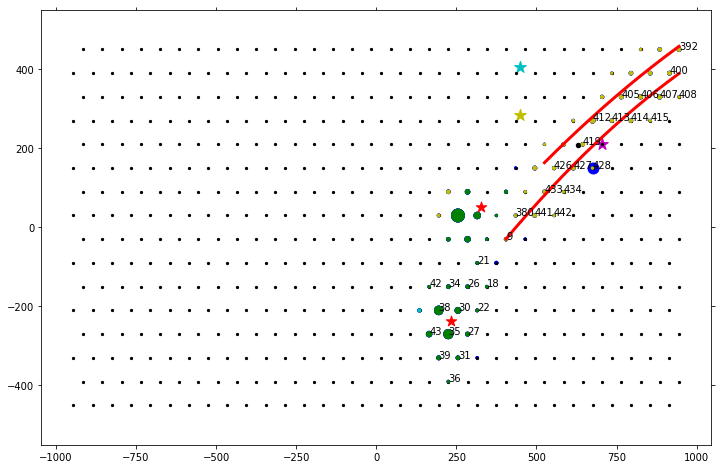

In [388]:
#plt.close('all')
fig,ax = plt.subplots(1,1, figsize=(12,8))
for i, row in neuronData.iterrows():
    eil.plotEiMarked(row['ei'], row['axon_elecs'], ax, elec_coords, size_fac=mysf,mymarkedfc='y',myalpha=1,mymarkedalpha=1,noArray=True,thr=-2)
    eil.plotEiMarked(row['ei'], row['soma_elecs'], ax, elec_coords, size_fac=mysf,mymarkedfc='g',myalpha=1,mymarkedalpha=1,noArray=True,thr=-2)
    eil.plotEiMarked(row['ei'], row['dend_elecs'], ax, elec_coords, size_fac=mysf,mymarkedfc='c',myalpha=1,mymarkedalpha=1,noArray=True,thr=-2)
    ax.scatter(row['soma_pos'][0],row['soma_pos'][1],marker='*',color='r',s=120,zorder=3)
    ax.plot(row['x'],row['p'](row['x']),lw=3,color='r')
ax.scatter(elec_coords[target_elec][0], elec_coords[target_elec][1], marker='o',color='b', s =120)
ax.scatter(values[2][1], values[2][2], marker='*',color='y', s =150)
ax.scatter(values[1][1], values[1][2], marker='*',color='c', s =150)
ax.scatter(values[0][1], values[0][2], marker='*',color='m', s =150)
ax.scatter(n_pointx, n_pointy, marker='o',color='k', s =20)
print(guess)
## Add labels for the stimulating electrodes and EI electrodes.
xcoords = elec_coords[:,0]
ycoords = elec_coords[:,1]
for e in soma_elecs:
    ax.annotate((e+1),(xcoords[e],ycoords[e]),size=10)
for e in axon_elecs:
    ax.annotate((e+1),(xcoords[e],ycoords[e]),size=10)
eil.plotArrayOnly(ax, elec_coords, size=5, myalpha=1, myfc='k', myec='k')
#plt.setp(ax, xlim=(0,1000), ylim=(0,1000))
plt.show()

In [389]:
print(values)

[[-10, 705, 210], [-1.168266064383861, 450, 405], [-4.450107189043052, 450, 285]]


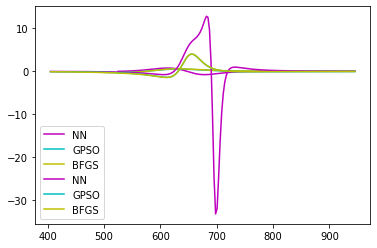

In [385]:
for index, row in neuronData.iterrows():
    yShow = [row['p'](x) for x in row['x']] 
    nnShow, gpsoShow, bfgsShow = values
    i_all[1] = nnShow[0]
    e_all[1] = (nnShow[1], nnShow[2])
    gradNN = np.gradient(actFunc3(p_e, i_all, step, e_all, row['x'], yShow))
    i_all[1] = gpsoShow[0]
    e_all[1] = (gpsoShow[1], gpsoShow[2])
    gradGPSO = np.gradient(actFunc3(p_e, i_all, step, e_all, row['x'], yShow))
    i_all[1] = bfgsShow[0]
    e_all[1] = (bfgsShow[1], bfgsShow[2])
    gradBFGS = np.gradient(actFunc3(p_e, i_all, step, e_all, row['x'], yShow))
    #i_all[1] = -5
    #e_all[1] = (elec_coords[395])
    #gradBFGS = np.gradient(actFunc3(p_e, i_all, step, e_all, row['x'], yShow))
    plt.plot(row['x'], gradNN, label='NN', color='m')
    plt.plot(row['x'], gradGPSO, label='GPSO', color='c')
    plt.plot(row['x'], gradBFGS, label='BFGS', color='y')
plt.legend()
plt.show()